In [1]:
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from scipy.ndimage import gaussian_filter1d

from bin.morphology.transforms import edge_transform, smooth
from bin.adj_image_array import invert
from bin.edge_loop import EdgeLoop

In [124]:
%matplotlib notebook

In [132]:
%matplotlib inline

In [4]:
def heaviside(x):
    return np.heaviside(x, 0)

In [5]:
def heaviside_continuous_approx(x, k=5):
    return np.where(x > 0, 2/(1 + np.exp(-k*x)) - 1, 0)

In [6]:
def delta(x):
    return x - np.roll(x, 1, 0)

In [7]:
def forward_delta(x):
    return np.roll(x, -1, 0) - x

In [8]:
def tangent(x):
    d = delta(x)
    return d #/ np.where(d == 0, 1, np.linalg.norm(d, axis=1)[:, None])

In [9]:
def normal(x):
    dt = forward_delta(delta(x))
    return dt #/ np.where(dt == 0, 1, np.linalg.norm(dt, axis=1)[:, None])

In [10]:
def gaussian_filter(x, sigma):
    return gaussian_filter1d(x, sigma, axis=0, mode='wrap')

In [11]:
def mask(n_g, t):
#     return heaviside(np.cross(n_g, t))
    return heaviside_continuous_approx(np.cross(n_g, t))

In [12]:
def concavity_f(sigma_g):
    def concavity(x):
        return sum(heaviside_continuous_approx(-np.cross(normal_g(x, sigma_g), tangent(x))))
#         return sum(-np.cross(normal_g(x, sigma_g), tangent(x)))
    return concavity

In [13]:
def normal_g(x, sigma_g):
    return gaussian_filter(normal(x), sigma_g)

In [14]:
def normal_gg(n_g, sigma_gg):
    return gaussian_filter(n_g, sigma_gg)

In [15]:
def step_f(sigma_g, sigma_gg):
    def step(x):
        n_g = normal_g(x, sigma_g)
        m = mask(n_g, tangent(x))
        
        return normal_gg(m[:, None] * n_g, sigma_gg)
    
    return step

In [76]:
def run_sim(edge, sigma_g=1, sigma_gg=1, step_size=1, n=100):
    step = step_f(sigma_g, sigma_gg)
    concavity = concavity_f(sigma_g)
    
    plt.figure()
    plt.fill(*edge.transpose(), fill=False)
    
    lengths = []
    avg_ds = []
    max_steps = []
    concavities = []
    for i in range(n):
        step_v = step(edge)
        step_i = step_size * step_v # / np.max(np.linalg.norm(step_v, axis=1))
        lengths.append(curve_length(edge))
        avg_ds.append(curve_length(edge) / edge.shape[0])
        max_steps.append(np.max(np.linalg.norm(step_i, axis=1)))
        concavities.append(concavity(edge))
        
        if concavities[-1] <= 0:
            break
        
        edge += step_i
        if not (i+1) % (n//100):
#             print(curve_length(edge))
            plt.fill(*edge.transpose(), color=(0.5, i/n, i/n), fill=False)
            
    plt.figure()
#     plt.plot(lengths / np.max(lengths))
    plt.plot(avg_ds)
    plt.figure()
    plt.plot(concavities)
    

In [258]:
def run_sim_discrete(edge, sigma_g=1, sigma_gg=1, step_size=1, n=100):
    step = step_f(sigma_g, sigma_gg)
    concavity = concavity_f(sigma_g)
    
    plt.figure()
    plt.fill(*edge.transpose(), fill=False)
    
    lengths = []
    sizes = []
    concavities = []
    
    for i in range(n):
        concavities.append(concavity(edge))
        
        if concavities[-1] <= 0:
            break        
        
        lengths.append(curve_length(edge))
        sizes.append(edge.shape[0])
                
        step_v = step(edge)
        step_i = step_size * step_v # / np.max(np.linalg.norm(step_v, axis=1))
        
        edge += step_i
        if i > 0 and abs(concavities[-2] - concavities[-1]) < 0.01:
            edge = np.around(edge)
            _, idx = np.unique(edge, axis=0, return_index=True)
            edge = edge[np.sort(idx)]
#             step_size *= 2
        
        if not (i+1) % (n//n):
            plt.fill(*edge.transpose(), color=(0.5, i/n, i/n), fill=False)
          
    plt.figure()
    plt.plot(concavities)
    plt.figure()
    plt.plot([concavities[i] - concavities[i-1] for i in range(1, len(concavities))])
    plt.figure()
    plt.plot(sizes)
        

In [18]:
def curve_length(curve):
    return sum(np.linalg.norm(curve - np.roll(curve, 1, 0), axis=1))

In [157]:
def run_sim_subsample(edge, sigma_g=1, sigma_gg=1, step_size=1, n=100):
    step = step_f(sigma_g, sigma_gg)
    concavity = concavity_f(sigma_g)
    
    plt.figure()
    plt.fill(*edge.transpose(), fill=False)
    
    lengths = []
    avg_ds = []
    max_steps = []
    concavities = []
    for i in range(n):
        
        concavities.append(concavity(edge))
        
        if concavities[-1] <= 0:
            break        
            
        avg_d = curve_length(edge) / edge.shape[0]
        if avg_d < 1:
            edge = edge[::2]
            avg_d = curve_length(edge) / edge.shape[0]
            
        avg_ds.append(avg_d)
        
        lengths.append(curve_length(edge))
        

        if i > 0 and abs(concavities[-2] - concavities[-1]) < 0.01 / step_size:
            step_size *= 2
            edge = edge[::2]
            avg_d = curve_length(edge) / edge.shape[0]
#             print(step_size)
            
        step_v = step(edge)
        step_i = step_size * step_v # / np.max(np.linalg.norm(step_v, axis=1))
        max_steps.append(np.max(np.linalg.norm(step_i, axis=1)))
        
        edge += step_i
        if not (i+1) % (n//1000):
#             print(curve_length(edge))
            plt.fill(*edge.transpose(), color=(0.5, i/n, i/n), fill=False)
    
    plt.fill(*edge.transpose(), color=(0.5, 1, 1), fill=False)
            
    plt.figure()
#     plt.plot(lengths / np.max(lengths))
    plt.plot(avg_ds)
    plt.figure()
    plt.plot(concavities)
    plt.figure()
    plt.plot([avg_ds[i] - avg_ds[i-1] for i in range(1, len(avg_ds))])
    plt.figure()
    plt.plot([concavities[i] - concavities[i-1] for i in range(1, len(concavities))])
    

In [256]:
im = np.pad(invert(np.array(Image.open('lib/polygon_test_shapes/test2.bmp').convert('L'))), 1)
im = smooth(im, 1)
e = np.array(EdgeLoop(im).edge_loop())

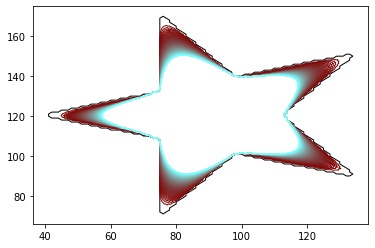

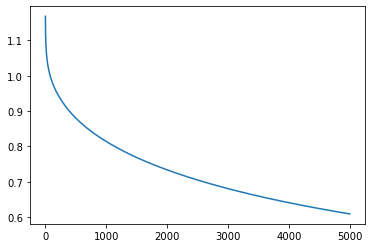

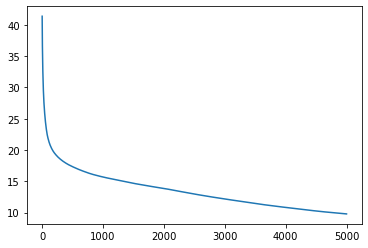

In [20]:
run_sim(e.astype(float)[::1], 1, 1, 2, 5000)

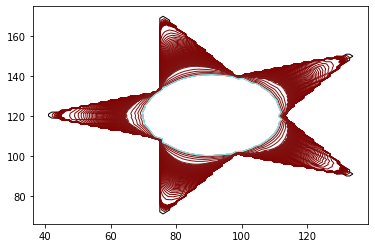

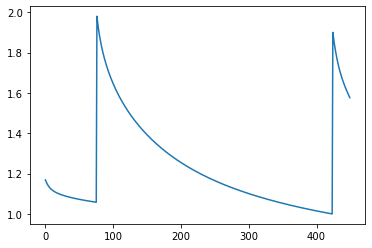

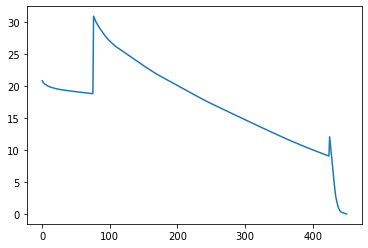

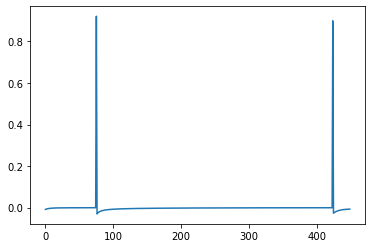

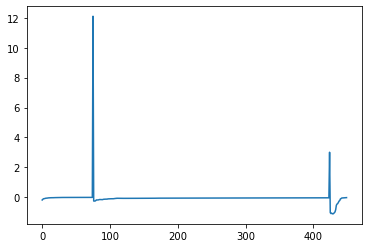

In [206]:
run_sim_subsample(e.astype(float)[::1], 1.4, 1.4, 1, 5000)

<ipython-input-5-0ab0112dde6f>:2: RuntimeWarning: overflow encountered in exp
  return np.where(x > 0, 2/(1 + np.exp(-k*x)) - 1, 0)
<ipython-input-5-0ab0112dde6f>:2: RuntimeWarning: overflow encountered in exp
  return np.where(x > 0, 2/(1 + np.exp(-k*x)) - 1, 0)
<ipython-input-5-0ab0112dde6f>:2: RuntimeWarning: overflow encountered in exp
  return np.where(x > 0, 2/(1 + np.exp(-k*x)) - 1, 0)
<ipython-input-5-0ab0112dde6f>:2: RuntimeWarning: overflow encountered in exp
  return np.where(x > 0, 2/(1 + np.exp(-k*x)) - 1, 0)
<ipython-input-5-0ab0112dde6f>:2: RuntimeWarning: overflow encountered in exp
  return np.where(x > 0, 2/(1 + np.exp(-k*x)) - 1, 0)
<ipython-input-5-0ab0112dde6f>:2: RuntimeWarning: overflow encountered in exp
  return np.where(x > 0, 2/(1 + np.exp(-k*x)) - 1, 0)
<ipython-input-5-0ab0112dde6f>:2: RuntimeWarning: overflow encountered in exp
  return np.where(x > 0, 2/(1 + np.exp(-k*x)) - 1, 0)
<ipython-input-5-0ab0112dde6f>:2: RuntimeWarning: overflow encountered in ex

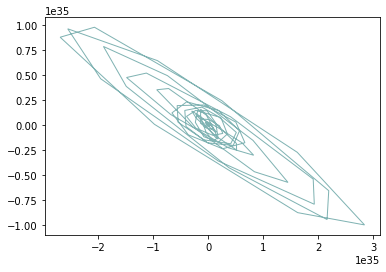

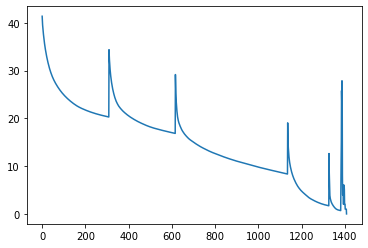

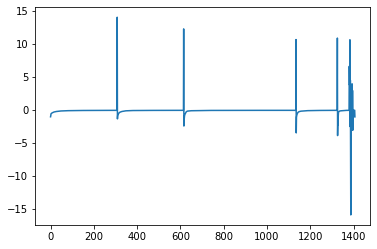

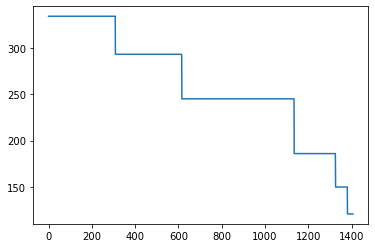

In [259]:
run_sim_discrete(e.astype(float), 1, 1, 1, 2000)

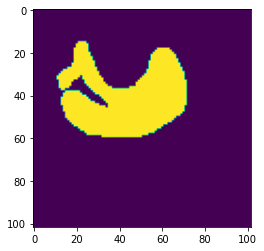

In [161]:
im = np.pad(invert(np.array(Image.open('lib/polygon_test_shapes/test4.bmp').convert('L'))), 1)
im = smooth(im, 1)
plt.figure()
plt.imshow(im)
e = np.array(EdgeLoop(im).edge_loop())

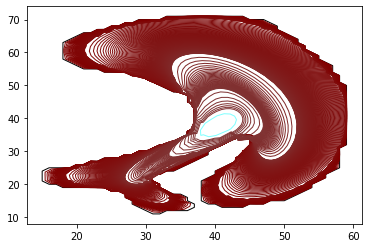

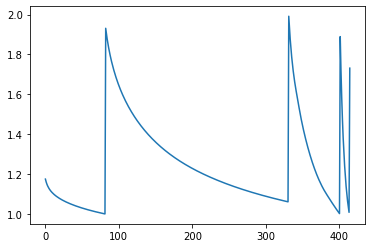

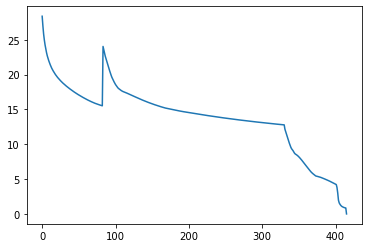

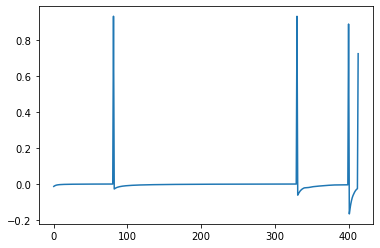

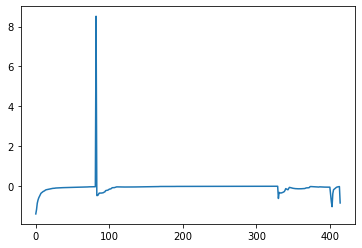

In [162]:
run_sim_subsample(e.astype(float)[::1], 1, 1, 1, 2000)

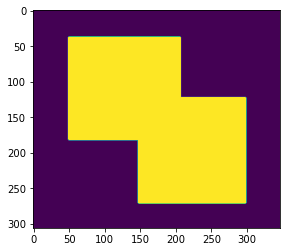

In [250]:
im = np.pad(invert(np.array(Image.open('lib/shapes/overlapped_squares.bmp').convert('L'))), 1)
im = smooth(im, 1)
plt.figure()
plt.imshow(im)
e = np.array(EdgeLoop(im).edge_loop())

<ipython-input-5-0ab0112dde6f>:2: RuntimeWarning: overflow encountered in exp
  return np.where(x > 0, 2/(1 + np.exp(-k*x)) - 1, 0)


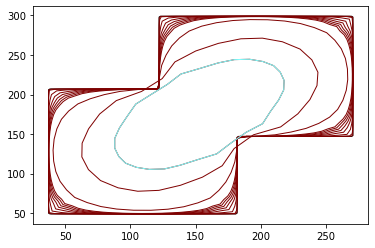

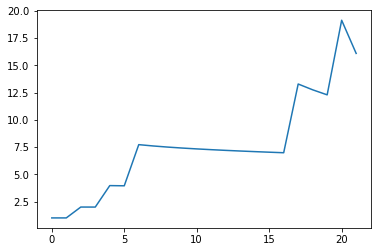

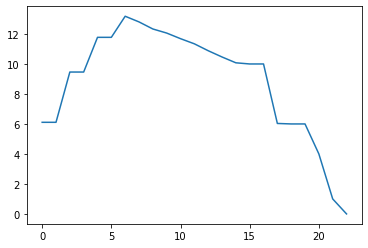

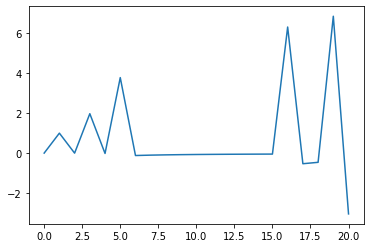

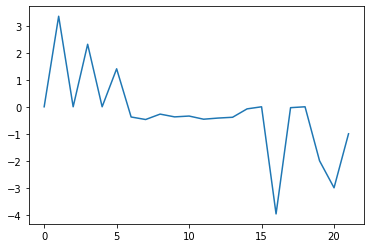

In [176]:
run_sim_subsample(e.astype(float)[::1], 1, 1, 0.1, 2000)

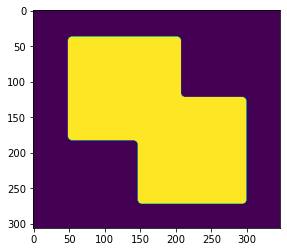

In [192]:
im = np.array(Image.open('lib/shapes/overlapped_squares.bmp').convert('L'))
im = smooth(im, 4)
im = np.pad(invert(im), 1)
im = smooth(im, 4)
plt.figure()
plt.imshow(im)
e = np.array(EdgeLoop(im).edge_loop())

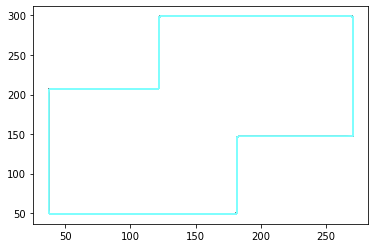

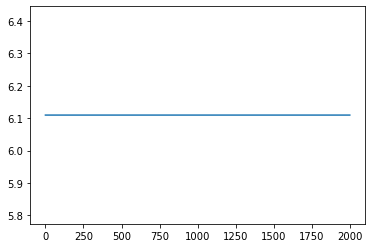

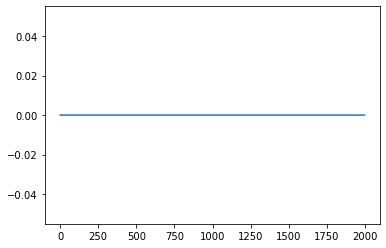

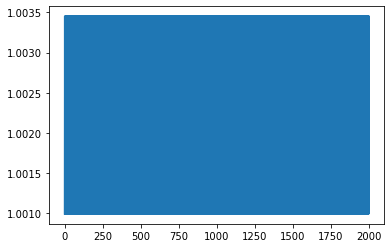

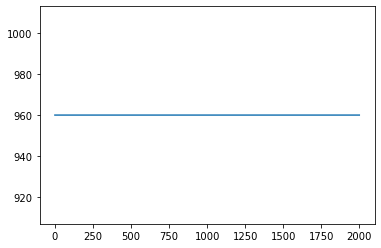

In [251]:
run_sim_discrete(e.astype(float)[::1], 1, 1, 1, 2000)

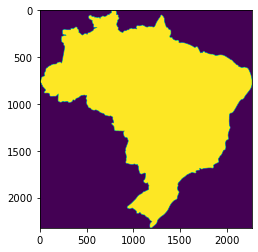

In [252]:
im = np.pad(invert(np.array(Image.open('lib/silhouettes/brazil-silhouette.bmp').convert('L'))), 1)
im = smooth(im, 1)
plt.figure()
plt.imshow(im)
e = np.array(EdgeLoop(im).edge_loop())

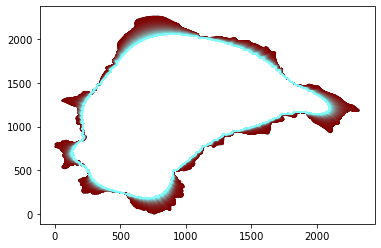

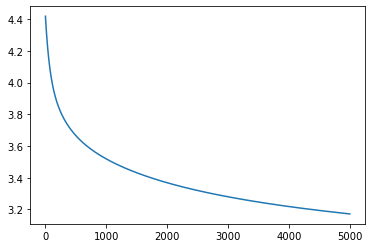

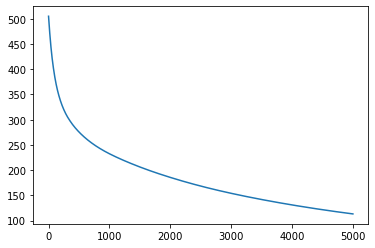

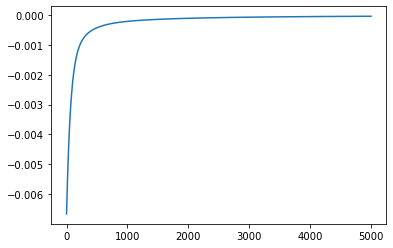

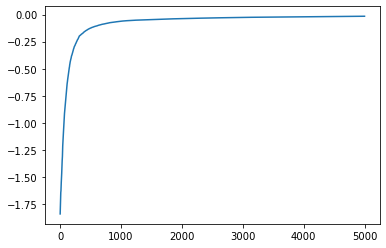

In [212]:
run_sim_subsample(e.astype(float)[::4], 10, 10, 5, 5000)

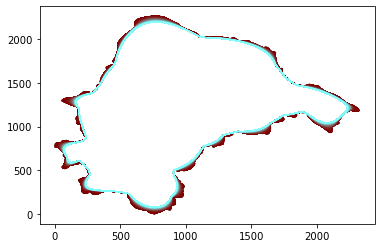

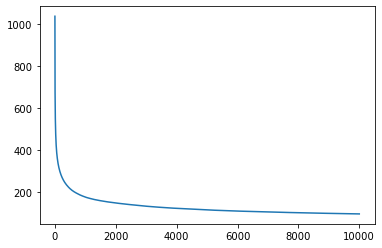

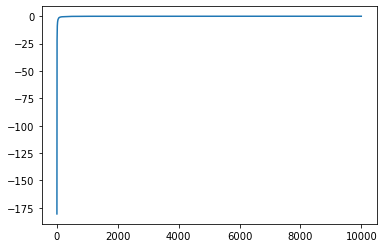

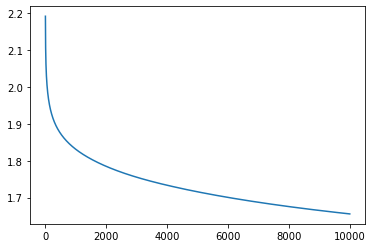

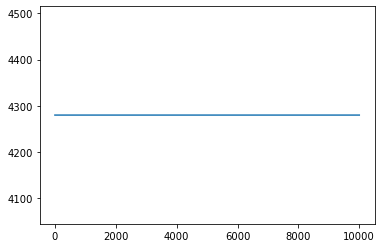

In [253]:
run_sim_discrete(e.astype(float)[::2], 1, 1, 5, 10000)